# K-NN on Amazon Food review Dataset

K-NN is a supervied machine learning algorithm that can be used to predict polarity of reviews in amazon fine foods dataset obtained from kaggle. (https://www.kaggle.com/snap/amazon-fine-food-reviews)

In this ipython notebook,following steps are performed:
    1. Load cleaned and preprocessed data
    2. Convert text to vector using one of the following methods
        a.bag of words
        b.tf-idf
        c.average word2vec
        d.tf-idf word2vec
    3. Apply KNN
        a. normalise data
        b. divide data into test and train
        c. find the optimal K using 10 fold cross validation
        d. apply brute force method to find K nearest neighbours
        e. use Kd-tree method to kind K nearest neighbours
    4. Performance measurement
        a. accuracy
        b. confusion matrix
        c. presicion, recall and f1-score

1.Load data

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#Using sqlite3 to retrieve data from sqlite file
con = sqlite3.connect(r'C:\Users\Admin\Downloads\final.sqlite')

#Read data from the sqlite file
data = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)


In [2]:
# data.drop('index', inplace=True, axis=1)
# data = data[data.index != 258456]
data.sort_values('Time',inplace=True,ascending=False)
# data.reset_index(drop=True, inplace=True)
#sampled_data = cleaned_data.sample(frac=0.275,random_state=1), time series split function can also be used.
sampled_data=data[:12000]

In [3]:
#We use 70% of data for training and 30% of data for test
import math
sampled_data.sort_values('Time',inplace=True,ascending=True) 

X_train =  sampled_data[:math.ceil(len(sampled_data)*.7)] 
X_test = sampled_data[math.ceil(len(sampled_data)*.3):]
y_train = sampled_data['Score'][:math.ceil(len(sampled_data)*.7)]
y_test =  sampled_data['Score'][math.ceil(len(sampled_data)*.3):]

2.Convert text to vector

Bag of words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer() 
bow_model = count_vect.fit(X_train['CleanedText'])
final_bow_train = bow_model.transform(X_train['CleanedText'])
final_bow_test = bow_model.transform(X_test['CleanedText'])

3.Apply K-NN

3.1 Normalise data

In [5]:
from sklearn.preprocessing import StandardScaler

normalised_bow_train = StandardScaler(with_mean=False).fit_transform(final_bow_train)
normalised_bow_test = StandardScaler(with_mean=False).fit_transform(final_bow_test)

3.2 Find optimal k using 10 fold cross-validation

In [7]:
from sklearn.cross_validation import cross_val_score

def find_optimal_k(X_train,y_train, kvalues):
   
    neighbors = list(filter(lambda x: x % 2 != 0, kvalues))

    # List to store cross validation data
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        score = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(score.mean())

    # finding error to find optimal K
    error = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[error.index(min(error))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)
    
    
    sns.set_style("darkgrid")
    plt.plot(neighbors,error)
    plt.xlabel("K Nearest Neighbours")
    plt.ylabel("Error")
    plt.title("Accuracy for different k values")
    plt.show()
      
    return optimal_k


The optimal number of neighbors is 5.


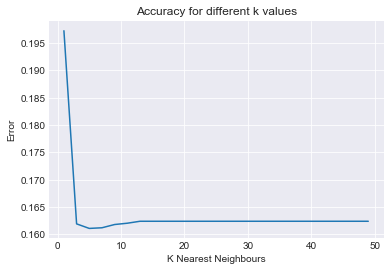

In [8]:
from sklearn.neighbors import KNeighborsClassifier
kvalues = list(range(0,50))

optimal_k = find_optimal_k(normalised_bow_train ,y_train,kvalues)

3.3 Predict polarity using brute force method for k-nn

In [9]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(normalised_bow_train, y_train)
brute_pred = knn.predict(normalised_bow_test)

3.4 Predict polarity using kd-tree method

In [10]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(normalised_bow_train,y_train)
kd_pred = knn.predict(normalised_bow_test)

4.Performance measurement

In [11]:
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

performance measurement on brute force method

Confusion Matrix of test set:


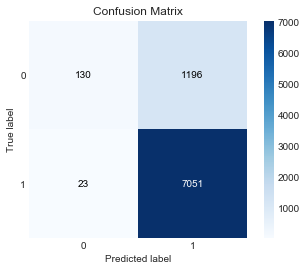

In [12]:
import scikitplot.metrics as skplt
print("Confusion Matrix of test set:")
skplt.plot_confusion_matrix(y_test ,brute_pred)

In [13]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, brute_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, brute_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, brute_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, brute_pred)))

Accuracy on test set: 85.488%
Precision on test set: 0.855
Recall on test set: 0.997
F1-Score on test set: 0.920


performance measurement on kd-tree method

Confusion Matrix of test set:


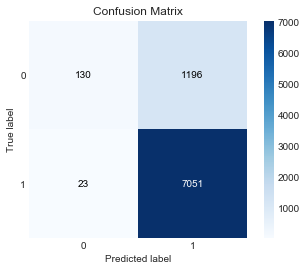

In [14]:
print("Confusion Matrix of test set:")
skplt.plot_confusion_matrix(y_test ,kd_pred)

In [15]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, kd_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, kd_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, kd_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, kd_pred)))

Accuracy on test set: 85.488%
Precision on test set: 0.855
Recall on test set: 0.997
F1-Score on test set: 0.920


TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vec = TfidfVectorizer()
tfidf_model = tf_idf_vec.fit(X_train['CleanedText'])
final_tfidf_train = tfidf_model.transform(X_train['CleanedText'])
final_tfidf_test = tfidf_model.transform(X_test['CleanedText'])

In [17]:
normalised_tfidf_train = StandardScaler(with_mean=False).fit_transform(final_tfidf_train)
normalised_tfidf_test = StandardScaler(with_mean=False).fit_transform(final_tfidf_test)


The optimal number of neighbors is 3.


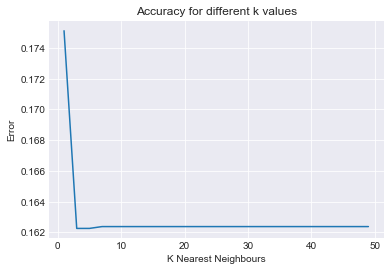

In [18]:
kvalues = list(range(0,50))

optimal_k = find_optimal_k(normalised_tfidf_train ,y_train,kvalues)

In [19]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(normalised_tfidf_train, y_train)
brute_pred = knn.predict(normalised_tfidf_test)

In [20]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(normalised_tfidf_train,y_train)
kd_pred = knn.predict(normalised_tfidf_test)

Confusion Matrix of test set:


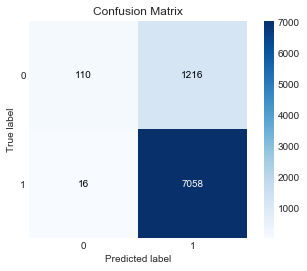

In [21]:
print("Confusion Matrix of test set:")
skplt.plot_confusion_matrix(y_test ,brute_pred)

In [22]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, brute_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, brute_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, brute_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, brute_pred)))

Accuracy on test set: 85.333%
Precision on test set: 0.853
Recall on test set: 0.998
F1-Score on test set: 0.920


Confusion Matrix of test set:


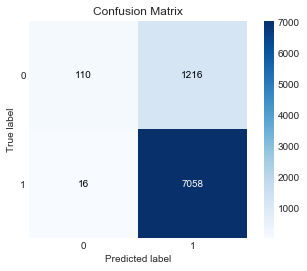

In [23]:
print("Confusion Matrix of test set:")
skplt.plot_confusion_matrix(y_test ,kd_pred)

In [24]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, kd_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, kd_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, kd_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, kd_pred)))

Accuracy on test set: 85.333%
Precision on test set: 0.853
Recall on test set: 0.998
F1-Score on test set: 0.920


Avg w2v

In [25]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim
import pickle

In [26]:
import re
import string
import nltk
from nltk.corpus import stopwords

stop = set(stopwords.words('english')) #set of stopwords
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [27]:
i=0
str1=''
list_of_sent_train=[]
final_string_for_tfidf_train = []
for sent in X_train['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
  
    list_of_sent_train.append(filtered_sentence)
    final_string_for_tfidf_train.append((str1).strip())

In [28]:
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in sampled_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
  
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())

In [29]:
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=2)

In [30]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [31]:
X_train = sent_vectors[:math.ceil(len(sampled_data)*.7)]  #final_w2v_count
X_test = sent_vectors[math.ceil(len(sampled_data)*.3):] #final_w2v_count

In [ ]:
# np.isnan(X_train)
# np.isnan(X_test)
# np.where(np.isnan(X_train))
# np.where(np.isnan(X_test))

In [32]:
X_train=np.nan_to_num(X_train)
X_test=np.nan_to_num(X_test)

In [33]:
from sklearn.preprocessing import StandardScaler
normalised_w2v_train = StandardScaler(with_mean=False).fit_transform(X_train)
normalised_w2v_test = StandardScaler(with_mean=False).fit_transform(X_test)


The optimal number of neighbors is 45.


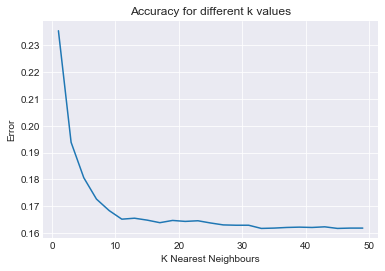

In [34]:
kvalues = list(range(0,50))

optimal_k = find_optimal_k(normalised_w2v_train ,y_train,kvalues)

In [35]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(normalised_w2v_train, y_train)
brute_pred = knn.predict(normalised_w2v_test)

In [36]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(normalised_w2v_train,y_train)
kd_pred = knn.predict(normalised_w2v_test)

Confusion Matrix of test set:


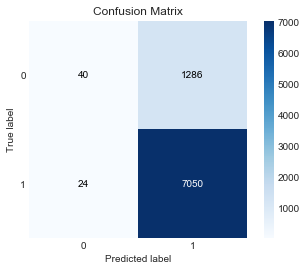

In [37]:
print("Confusion Matrix of test set:")
skplt.plot_confusion_matrix(y_test ,brute_pred)

In [38]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, brute_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, brute_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, brute_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, brute_pred)))

Accuracy on test set: 84.405%
Precision on test set: 0.846
Recall on test set: 0.997
F1-Score on test set: 0.915


Confusion Matrix of test set:


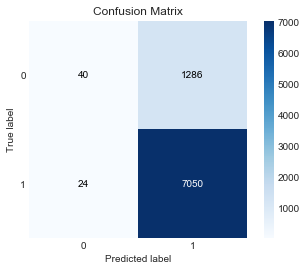

In [39]:
print("Confusion Matrix of test set:")
skplt.plot_confusion_matrix(y_test ,kd_pred)

In [40]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, kd_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, kd_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, kd_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, kd_pred)))

Accuracy on test set: 84.405%
Precision on test set: 0.846
Recall on test set: 0.997
F1-Score on test set: 0.915


tf-idf weighted word2vec

In [41]:
tf_idf_w2v = TfidfVectorizer()
tfidf_model = tf_idf_w2v.fit(final_string_for_tfidf_train)
final_tfidf_w=tfidf_model.transform(final_string_for_tfidf)

In [42]:
tfidf_feat = tf_idf_w2v.get_feature_names()


tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [43]:
X_train = tfidf_sent_vectors[:math.ceil(len(sampled_data)*.7)]  #final_w2v_count
X_test = tfidf_sent_vectors[math.ceil(len(sampled_data)*.3):] #final_w2v_count

In [45]:
X_train=np.nan_to_num(X_train)
X_test=np.nan_to_num(X_test)


The optimal number of neighbors is 37.


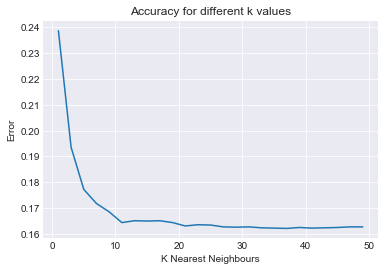

In [46]:
kvalues = list(range(0,50))

optimal_k = find_optimal_k(X_train ,y_train,kvalues)

In [47]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
brute_pred = knn.predict(X_test)

In [48]:
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(X_train,y_train)
kd_pred = knn.predict(X_test)

Confusion Matrix of test set:


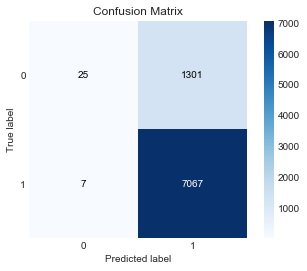

In [49]:
print("Confusion Matrix of test set:")
skplt.plot_confusion_matrix(y_test ,brute_pred)

In [50]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, brute_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, brute_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, brute_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, brute_pred)))

Accuracy on test set: 84.429%
Precision on test set: 0.845
Recall on test set: 0.999
F1-Score on test set: 0.915


Confusion Matrix of test set:


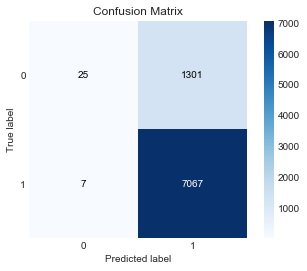

In [51]:
print("Confusion Matrix of test set:")
skplt.plot_confusion_matrix(y_test ,kd_pred)

In [52]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, kd_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, kd_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, kd_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, kd_pred)))

Accuracy on test set: 84.429%
Precision on test set: 0.845
Recall on test set: 0.999
F1-Score on test set: 0.915


# Conclusion:
For 12k datapoints, bag of words works the best using 5 nearest neighbours with an accuracy of 85.48.
Irrespective of the method used to convert text to vector, KD-tree and brute force method both give the same results.
TF-IDF provided an accuracy of 85.33%